# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [191]:
# Imports
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [192]:
class TreeEnsemble(BaseEstimator):
    def __init__(self, n_trees: 100, n_samples = None, n_features = 1.0, min_leaf = 1):
        """Initialize regression estimator.
        
        `n_trees`: number of trees in ensemble (same as sklearn's n_estimators)
        `n_samples`: size of the sample set to use of each of the trees in the forest (same as sklearn's max_samples)
            If None: equal to length of training set
            If int: number of training samples to draw
            If float: fraction of length of training set
        `n_features`: number of features to sample (same as sklearn's max_features)
            If int: use specified number of features
            If float: fraction of total number of features
        `min_leaf`: minimum number of samples in each leaf node of each tree in the forest (same as sklearn's min_samples_leaf)
        """
        self.n_trees = n_trees
        self.n_samples = n_samples
        self.n_features = n_features
        self.min_leaf = min_leaf
        self._trees = []
        self._oob_predictions = None # pd.Series of len samples containing out of bag predictions
        self._oob_mse = 0

    def fit(self, X, y):
        self._update_params(X)
        rng = np.random.default_rng()
        self._trees = []
        oob_predictions = np.nan * np.ones((X.shape[0], self.n_trees))
        all_data_idx = set(range(X.shape[0]))
        for tree_idx in range(self.n_trees):
            # Get random sample of training data.
            sample_idx = rng.choice(len(all_data_idx), self.n_samples, replace=True)
            # Out of bag samples are those samples not used to train the tree (this iteration).
            oob_sample_idx = np.array(list(all_data_idx - set(sample_idx)))
            # Get random features.
            feature_idx = rng.choice(X.shape[1], self.n_features, replace=False)

            # Split dataset used to train tree from OOB data.
            X_train = X[sample_idx, :]
            y_train = y[sample_idx]
            X_oob = X[oob_sample_idx, :]

            tree = make_pipeline(
                ColumnTransformer([("feature_select", "passthrough", feature_idx)], remainder="drop"),
                DecisionTreeRegressor(min_samples_leaf=self.min_leaf))
            tree.fit(X_train, y_train)

            oob_predictions[oob_sample_idx, tree_idx] = tree.predict(X_oob)
            self._trees.append(tree)

        # Compute predictions for out of bag samples.
        self._oob_predictions = pd.DataFrame(oob_predictions).mean(axis=1)
        # Compute average OOB MSE.
        oob_pred = pd.concat([self._oob_predictions.to_frame(name="pred"), pd.Series(y, name="true")], axis=1)
        oob_pred.dropna(inplace=True) # Drop samples without any predictions.
        self._oob_mse = metrics.mean_squared_error(oob_pred["true"], oob_pred["pred"])
        
        return self

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self._trees)))
        for i, tree in enumerate(self._trees):
            predictions[:, i] = tree.predict(X)
        return predictions.mean(axis=1)

    def oob_predictions(self):
        return self._oob_predictions.values

    def oob_mse(self):
        return self._oob_mse

    def _update_params(self, X):
        self._update_n_samples(X)
        self._update_n_features(X)
    
    def _update_n_samples(self, X):
        if self.n_samples is None:
            self.n_samples = X.shape[0]
        elif isinstance(self.n_samples, float):
            if 0 < self.n_samples <= 1.0:
                self.n_samples = int(round(self.n_samples * X.shape[0]))
            else:
                raise ValueError(f"If sample_sz is a float, it must be in (0, 1]: {self.n_samples}")
        elif isinstance(self.n_samples, int):
            if self.n_samples > X.shape[0]:
                self.n_samples = X.shape[0]
            if self.n_samples <= 0:
                raise ValueError(f"If sample_sz is an int, it must be greater than 0: {self.n_samples}")
        else:
            raise TypeError(f"Invalid type for sample_sz: {self.n_samples}")

    def _update_n_features(self, X):
        if isinstance(self.n_features, float):
            if 0 < self.n_features <= 1.0:
                self.n_features = int(round(self.n_features * X.shape[1]))
            else:
                raise ValueError(f"If n_features is a float, it must be in (0, 1]: {self.n_features}")
        elif isinstance(self.n_features, int):
            if self.n_features > X.shape[1]:
                self.n_features = X.shape[1]
            if self.n_features <= 0:
                raise ValueError(f"If n_features is an int, it must be greater than 0: {self.n_features}")
        else:
            raise TypeError(f"Invalid type for n_features: {self.n_features}")

In [193]:
X, y = load_boston(return_X_y=True)

C:\Users\Lior\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [195]:
results = []
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(n_trees=n, n_samples=sz, min_leaf=min_leaf)
      cv_scores = cross_validate(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, return_train_score=True)
      forest.fit(X_train, y_train)
      results.append({
        "n_trees": n,
        "sample_sz": sz,
        "min_leaf": min_leaf,
        "oob_mse": forest.oob_mse(),
        "train_mse_mean": -1.0 * cv_scores["train_score"].mean(),
        "train_mse_std": cv_scores["train_score"].std(),
        "validation_mse_mean": -1.0 * cv_scores["test_score"].mean(),
        "validation_mse_std": cv_scores["test_score"].std(),
      })
results_df = pd.DataFrame(results).sort_values("oob_mse")
results_df

,n_trees,sample_sz,min_leaf,oob_mse,train_mse_mean,train_mse_std,validation_mse_mean,validation_mse_std
46,100,500,1,11.194295,1.721920,0.220731,12.237921,3.372110
38,50,500,1,11.357445,1.880872,0.294433,11.583810,3.502657
36,50,300,1,11.698895,2.425435,0.303442,13.430632,4.238489
44,100,300,1,12.135729,2.397282,0.286503,12.828915,3.490894
28,20,300,1,12.536466,2.630764,0.528885,13.698700,2.606428
30,20,500,1,13.090289,1.847868,0.248927,13.658525,5.225415
47,100,500,5,13.279410,5.331288,0.527838,14.282607,3.330231
31,20,500,5,13.487168,5.754711,1.166839,14.720125,2.442865
22,10,500,1,13.504249,2.430869,0.339477,13.340815,3.770262
39,50,500,5,14.079929,5.430059,0.565551,14.600433,3.156605


OOB MSE: 12.28
Train MSE: 3.29
Test MSE: 7.33
All Data MSE: 3.79


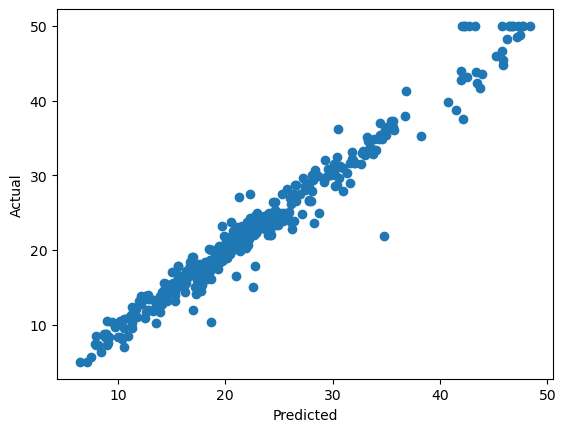

In [196]:
best = TreeEnsemble(n_trees=100, n_samples=300, min_leaf=1)
best.fit(X_train, y_train)
y_pred = best.predict(X)
print(f"OOB MSE: {best.oob_mse():.2f}")
print(f"Train MSE: {metrics.mean_squared_error(y_train, best.predict(X_train)):.2f}")
print(f"Test MSE: {metrics.mean_squared_error(y_test, forest.predict(X_test)):.2f}")
print(f"All Data MSE: {metrics.mean_squared_error(y, y_pred):.2f}")
plt.scatter(best.predict(X_train), y_train)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Using sklearn

In [197]:
results = []
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      cv_splits = 5
      train_size = int(X_train.shape[0] * (cv_splits - 1) / cv_splits)
      if sz > train_size:
        sz = train_size
      forest = RandomForestRegressor(n_estimators=n, max_samples=sz, min_samples_leaf=min_leaf, oob_score=True, n_jobs=-1)
      cv_scores = cross_validate(forest, X_train, y_train, scoring="neg_mean_squared_error", cv=cv_splits, return_train_score=True)
      forest.fit(X_train, y_train)
      results.append({
        "n_trees": n,
        "sample_sz": sz,
        "min_leaf": min_leaf,
        "oob_mse": metrics.mean_squared_error(y_train, forest.oob_prediction_),
        "train_mse_mean": -1.0 * cv_scores["train_score"].mean(),
        "train_mse_std": cv_scores["train_score"].std(),
        "validation_mse_mean": -1.0 * cv_scores["test_score"].mean(),
        "validation_mse_std": cv_scores["test_score"].std(),
      })
results_df = pd.DataFrame(results).sort_values("oob_mse")
results_df

C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably me

,n_trees,sample_sz,min_leaf,oob_mse,train_mse_mean,train_mse_std,validation_mse_mean,validation_mse_std
46,100,364,1,11.700881,1.727690,0.321910,12.799921,3.938577
38,50,364,1,11.816603,1.702322,0.224657,12.672875,3.922917
36,50,300,1,12.005967,2.522789,0.287716,13.311619,4.295483
44,100,300,1,12.463104,2.323161,0.243634,12.504823,3.831247
30,20,364,1,13.145214,1.795658,0.378480,12.980251,4.537624
20,10,300,1,14.033818,3.363674,0.720775,15.459728,3.534774
42,100,100,1,14.093688,8.743201,0.714671,14.717488,1.195794
28,20,300,1,15.292148,2.884418,0.397114,14.897055,4.280782
45,100,300,5,15.396230,8.074489,0.686238,15.959345,2.780197
47,100,364,5,15.413004,7.262299,0.463829,15.881647,3.102389


OOB MSE: 11.86
Train MSE: 3.11
Test MSE: 7.70
All Data MSE: 3.60


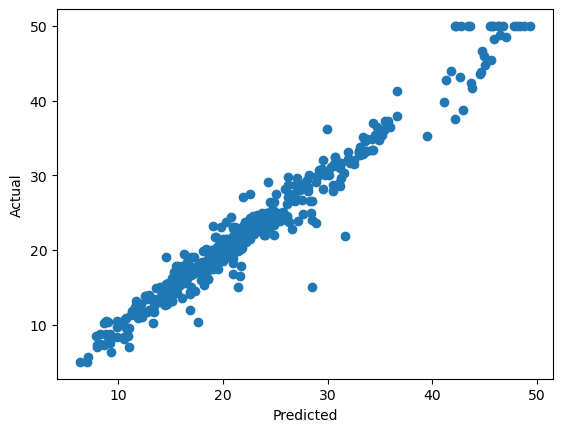

In [198]:
best = RandomForestRegressor(n_estimators=100, max_samples=300, min_samples_leaf=1, oob_score=True, n_jobs=-1)
best.fit(X_train, y_train)
y_pred = best.predict(X)
print(f"OOB MSE: {metrics.mean_squared_error(y_train, best.oob_prediction_):.2f}")
print(f"Train MSE: {metrics.mean_squared_error(y_train, best.predict(X_train)):.2f}")
print(f"Test MSE: {metrics.mean_squared_error(y_test, forest.predict(X_test)):.2f}")
print(f"All Data MSE: {metrics.mean_squared_error(y, y_pred):.2f}")
plt.scatter(y_pred, y)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

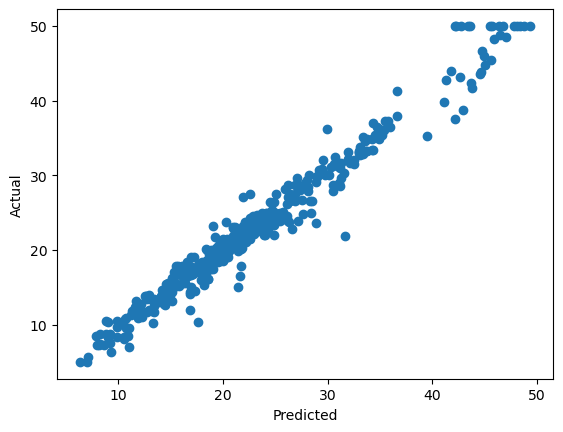

In [199]:
plt.scatter(best.predict(X_train), y_train)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 2. Implementing AdaBoost From Scratch 


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





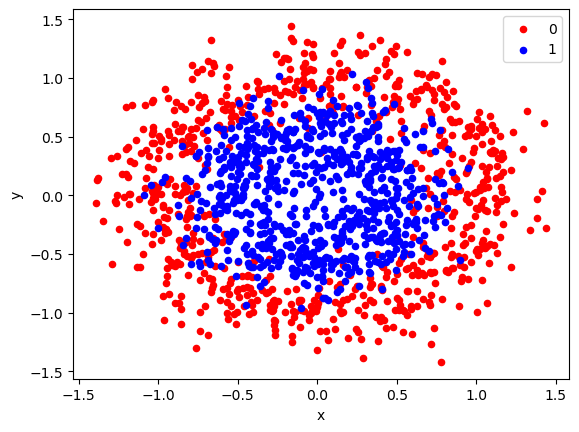

In [200]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [201]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

#### 2.1 Implement the AdaBoost algorithm for classification task. Your AdaBoost class should receive a method for creating a weak learner, which has a fit and predict methods (hint: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

In [202]:
# Decision stump used as weak classifier
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost():

    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

#### 2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [204]:
def plot_auc_vs_n_estimators(clf, clf_name):
    n_sweep = [1,5,10,20,50,100]
    auc = []
    train_auc = []
    for n in n_sweep:
        ensemble = AdaBoostClassifier(clf, n_estimators=n)
        ensemble.fit(X_train, y_train)
        train_auc.append(metrics.roc_auc_score(y_train, ensemble.predict(X_train)))
        auc.append(metrics.roc_auc_score(y_test, ensemble.predict(X_test)))

    best_idx = np.argmax(auc)
    print(f"Best {clf_name} (n_estimators={n_sweep[best_idx]}): {auc[best_idx]:.4f}")

    plt.plot(n_sweep, train_auc, label="train")
    plt.plot(n_sweep, auc, label="test")
    plt.title(f"{clf_name} (best={auc[best_idx]:.4f})")
    plt.xlabel("n_estimators")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

Best Decision Stump (n_estimators=20): 0.8800


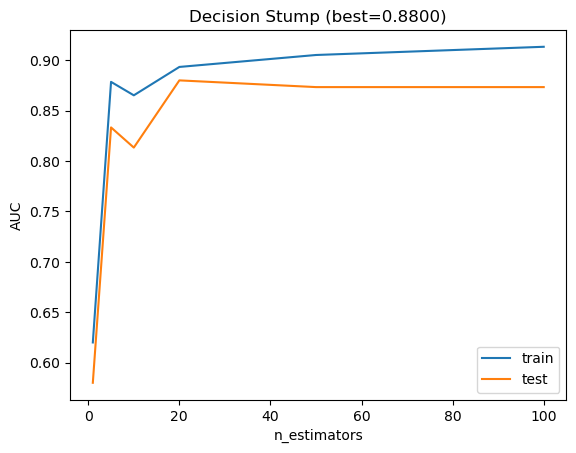

Best Decision Tree (depth=2) (n_estimators=10): 0.8733


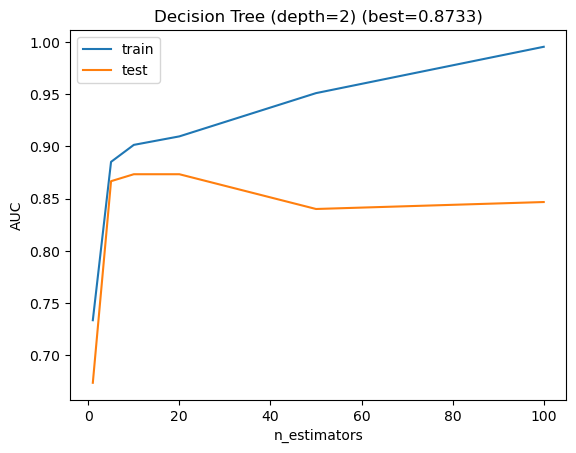

Best Decision Tree (depth=3) (n_estimators=5): 0.8733


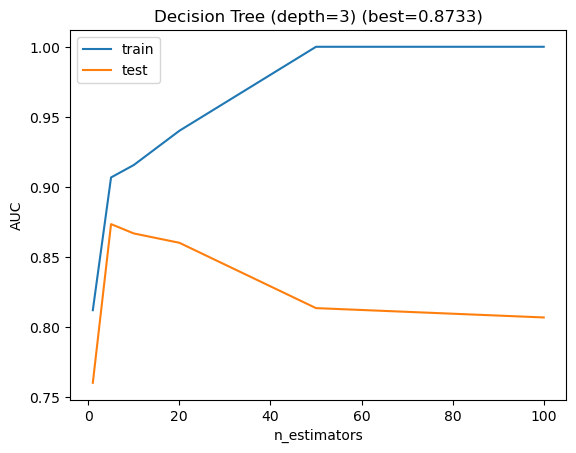

Best Logistic Regression (n_estimators=1): 0.5133


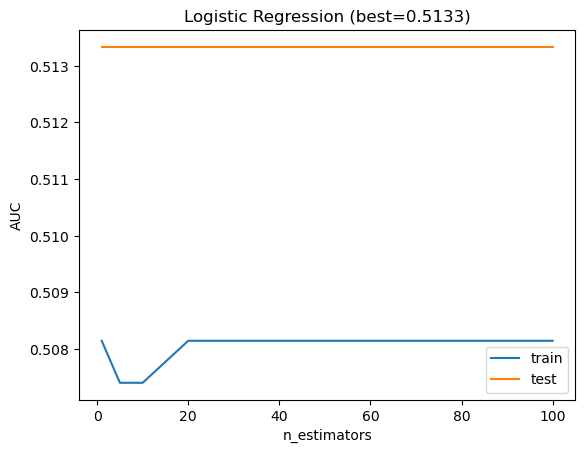

In [205]:
plot_auc_vs_n_estimators(DecisionTreeClassifier(max_depth=1), "Decision Stump")
plot_auc_vs_n_estimators(DecisionTreeClassifier(max_depth=2), "Decision Tree (depth=2)")
plot_auc_vs_n_estimators(DecisionTreeClassifier(max_depth=3), "Decision Tree (depth=3)")
plot_auc_vs_n_estimators(LogisticRegression(), "Logistic Regression")

In [206]:
def plot_predictions(n_estimators):
    ensemble = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X)

    data = pd.DataFrame(X).rename(columns={0: "x", 1: "y"})
    data = data.join(pd.Series(y, name="true")).join(pd.Series(y_pred, name="pred"))
    data["correct"] = data["true"] == data["pred"]

    # Compute TP, TN, FP, FN
    data["outcome"] = "TP"
    data.loc[data.correct & (data.pred == 0), "outcome"] = "TN"
    data.loc[~data.correct & (data.pred == 1), "outcome"] = "FP"
    data.loc[~data.correct & (data.pred == 0), "outcome"] = "FN"

    sns.scatterplot(data, x="x", y="y", hue="outcome", hue_order=["TN", "FN", "TP", "FP"])
    plt.title(f"n_estimators = {n_estimators}")
    plt.show()

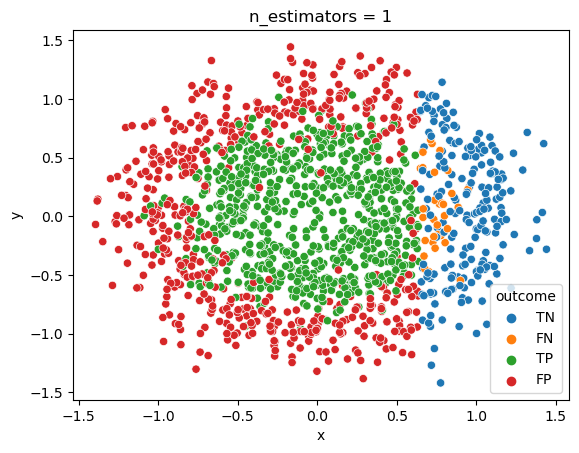

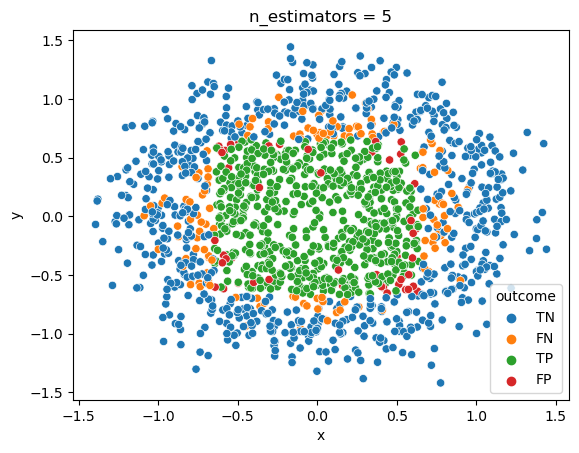

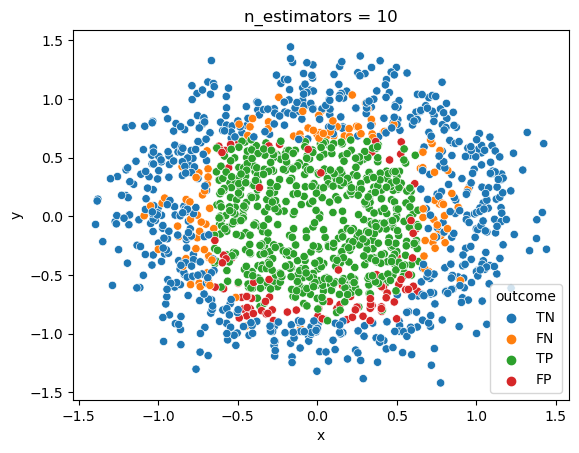

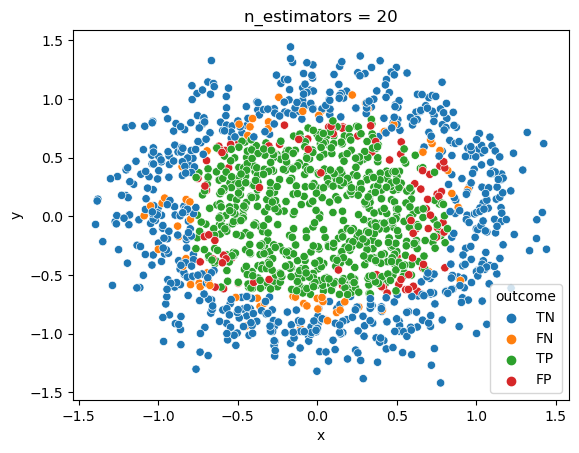

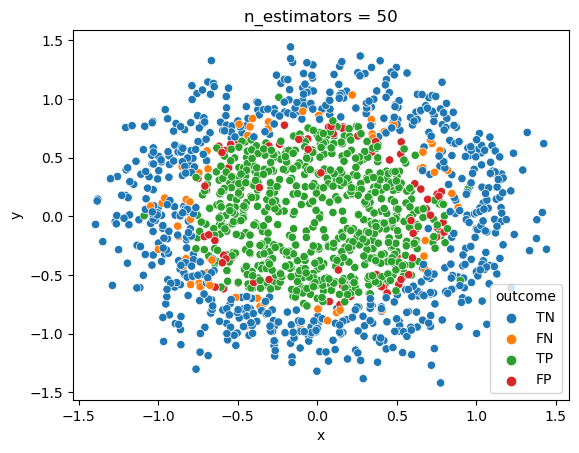

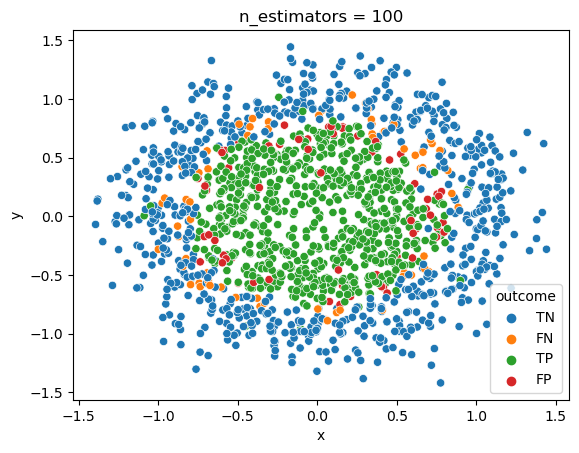

In [207]:
for n in [1,5,10,20,50,100]:
    plot_predictions(n)

Above n_estimators=20, the model starts to overfit

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

# Answers
### 1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.

In [208]:
class GradientBooster:
    def __init__(self, lr, n_iter):
        self.max_depth = 1
        self.min_samples_split = 5
        self.min_samples_leaf = 5
        self.max_features = 3
        self.lr = lr
        self.num_iter = n_iter
        self.y_mean = 0
        self.models = []
        self.training_errors = []
        
    def __calculate_loss(self,y, y_pred):
        loss = (1/len(y)) * 0.5 * np.sum(np.square(y-y_pred))
        return loss
    
    def __take_gradient(self, y, y_pred):
        grad = -(y-y_pred)
        return grad
    
    def train(self, X, y):
        self.y_mean = np.mean(y)
        y_pred = self.y_mean * np.ones(len(y))
        for i in range(self.num_iter):
            loss = self.__calculate_loss(y, y_pred)
            grad = self.__take_gradient(y, y_pred)
            model = DecisionTreeRegressor(max_depth = self.max_depth)
            model = model.fit(X,grad)
            self.models.append(model) 
            temp = model.predict(X)
            y_pred -= self.lr * temp  
            error_i = self.compute_error(y, y_pred)
            self.training_errors.append(error_i)
                
    def predict(self, X):
        y_pred = self.y_mean * np.ones(len(X))
        for i in range(self.num_iter):
            model = self.models[i]
            temp_y = model.predict(X)
            y_pred -= self.lr * temp_y   
        return y_pred
            
    def compute_error(self, y, y_pred):
        mse = np.square(np.subtract(y, y_pred)).mean()
        return mse

### 2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of n_trees up to 1,000. What is the optimal value of n_trees? of learning rate?

In [209]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

C:\Users\Lior\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

In [210]:
n_sweep = np.logspace(0,3, num=50).astype(int)
n_sweep =np.unique(n_sweep)
lr_sweep=[0.01,0.05,0.1,0.15]
mse_train = []
mse_test = []
for n in n_sweep:
    print(f"number of trees: {n}")
    GB = GradientBooster(lr=0.1, n_iter=n)
    GB.train(X_train, y_train)
    y_pred = GB.predict(X_train)
    mse = np.square(np.subtract(y_train, y_pred)).mean() 
    mse_train.append(mse)
    print(f"train set mse:{mse:.2f} ")
    y_pred = GB.predict(X_test)
    mse = np.square(np.subtract(y_test, y_pred)).mean() 
    mse_test.append(mse)
    print(f"test set mse:{mse:.2f} ")

number of trees: 1
train set mse:79.10 
test set mse:59.92 
number of trees: 2
train set mse:72.43 
test set mse:54.48 
number of trees: 3
train set mse:66.84 
test set mse:50.50 
number of trees: 4
train set mse:61.90 
test set mse:46.34 
number of trees: 5
train set mse:57.53 
test set mse:42.55 
number of trees: 6
train set mse:53.64 
test set mse:39.74 
number of trees: 7
train set mse:49.98 
test set mse:37.44 
number of trees: 8
train set mse:46.87 
test set mse:34.62 
number of trees: 9
train set mse:44.00 
test set mse:32.73 
number of trees: 10
train set mse:41.43 
test set mse:30.52 
number of trees: 12
train set mse:37.11 
test set mse:27.70 
number of trees: 14
train set mse:33.59 
test set mse:24.52 
number of trees: 16
train set mse:30.70 
test set mse:22.18 
number of trees: 19
train set mse:27.25 
test set mse:19.46 
number of trees: 22
train set mse:24.59 
test set mse:17.90 
number of trees: 25
train set mse:22.56 
test set mse:16.27 
number of trees: 29
train set mse

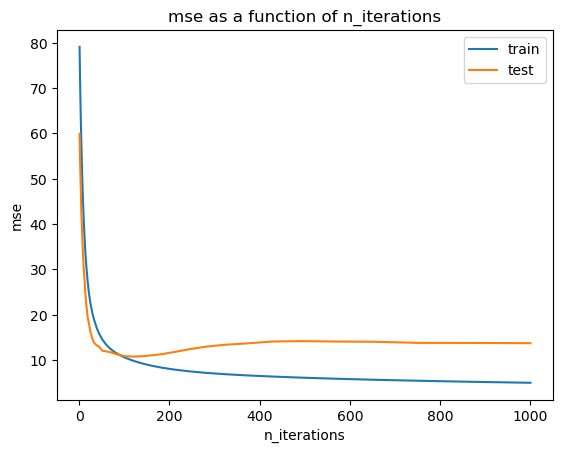

In [211]:
plt.plot(n_sweep, mse_train, label="train")
plt.plot(n_sweep, mse_test, label="test")
plt.xlabel("n_iterations")
plt.ylabel("mse")
plt.title('mse as a function of n_iterations')
plt.legend()
plt.show()

In [212]:
# learning rate opt

In [213]:
lr_sweep=[0.01,0.025,0.05,0.075, 0.1,0.12,0.15,0.2]
mse_train = []
mse_test = []
for lr in lr_sweep:
    #print(f"Train MSE: {metrics.mean_squared_error(y_train, best.predict(X_train)):.2f}")

    print(f"number of trees: {n}")
    GB = GradientBooster(lr=lr, n_iter=92)
    GB.train(X_train, y_train)
    y_pred = GB.predict(X_train)
    mse = np.square(np.subtract(y_train, y_pred)).mean() 
    mse_train.append(mse)
    print(f"train set mse:{mse:.2f}")
    y_pred = GB.predict(X_test)
    mse = np.square(np.subtract(y_test, y_pred)).mean() 
    mse_test.append(mse)
    print(f"test set mse:{mse:.2f}")

number of trees: 1000
train set mse:44.54
test set mse:32.92
number of trees: 1000
train set mse:24.48
test set mse:17.69
number of trees: 1000
train set mse:15.75
test set mse:12.73
number of trees: 1000
train set mse:12.57
test set mse:11.58
number of trees: 1000
train set mse:11.02
test set mse:11.10
number of trees: 1000
train set mse:10.23
test set mse:10.76
number of trees: 1000
train set mse:9.31
test set mse:10.69
number of trees: 1000
train set mse:8.28
test set mse:10.75


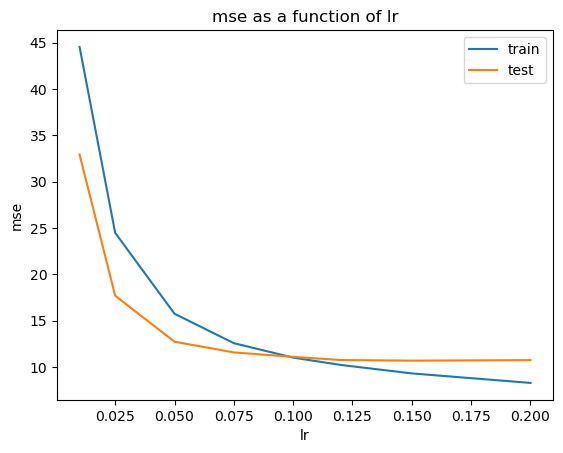

In [214]:
plt.plot(lr_sweep, mse_train, label="train")
plt.plot(lr_sweep, mse_test, label="test")
plt.xlabel("lr")
plt.ylabel("mse")
plt.title('mse as a function of lr')
plt.legend()
plt.show()

In [215]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000,criterion='mse',
                                    max_depth=8,min_samples_split=5,
                                    min_samples_leaf=5,max_features=3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))
#RMSE: 48744.67210701868

C:\Users\Lior\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: F

NameError: name 'mean_squared_error' is not defined

### 3. Compare the performance with a deep DecisionTreeRegressor (find the optimal max_depth). Who wins?

In [216]:
class GradientBoosterD:
    def __init__(self,max_d, lr, n_iter):
        self.max_depth = max_d
        self.min_samples_split = 5
        self.min_samples_leaf = 5
        self.max_features = 3
        self.lr = lr
        self.num_iter = n_iter
        self.y_mean = 0
        self.models = []
        self.training_errors = []
        
    def __calculate_loss(self,y, y_pred):
        loss = (1/len(y)) * 0.5 * np.sum(np.square(y-y_pred))
        return loss
    
    def __take_gradient(self, y, y_pred):
        grad = -(y-y_pred)
        return grad
    
    def train(self, X, y):
        self.y_mean = np.mean(y)
        y_pred = self.y_mean * np.ones(len(y))
        for i in range(self.num_iter):
            loss = self.__calculate_loss(y, y_pred)
            grad = self.__take_gradient(y, y_pred)
            model = DecisionTreeRegressor(max_depth = self.max_depth)
            model = model.fit(X,grad)
            self.models.append(model) 
            temp = model.predict(X)
            y_pred -= self.lr * temp  
            error_i = self.compute_error(y, y_pred)
            self.training_errors.append(error_i)
                
    def predict(self, X):
        y_pred = self.y_mean * np.ones(len(X))
        for i in range(self.num_iter):
            model = self.models[i]
            temp_y = model.predict(X)
            y_pred -= self.lr * temp_y   
        return y_pred
            
    def compute_error(self, y, y_pred):
        mse = np.square(np.subtract(y, y_pred)).mean()
        return mse

In [217]:
max_depth = np.array(range(1,20))
max_depth

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [218]:
max_depth = np.array(range(1,20))
mse_train = []
mse_test = []
for n_depth in max_depth:
    print(f"number of trees: {n}")
    GB = GradientBoosterD(max_d=n_depth,lr=0.075, n_iter=130)
    GB.train(X_train, y_train)
    y_pred = GB.predict(X_train)
    mse = np.square(np.subtract(y_train, y_pred)).mean() 
    mse_train.append(mse)
    print(f"train set mse:{mse:.2f} ")
    y_pred = GB.predict(X_test)
    mse = np.square(np.subtract(y_test, y_pred)).mean() 
    mse_test.append(mse)
    print(f"test set mse:{mse:.2f} ")

number of trees: 1000
train set mse:10.79 
test set mse:10.84 
number of trees: 1000
train set mse:4.65 
test set mse:8.33 
number of trees: 1000
train set mse:2.06 
test set mse:4.64 
number of trees: 1000
train set mse:0.89 
test set mse:6.27 
number of trees: 1000
train set mse:0.26 
test set mse:5.69 
number of trees: 1000
train set mse:0.05 
test set mse:4.78 
number of trees: 1000
train set mse:0.01 
test set mse:6.19 
number of trees: 1000
train set mse:0.00 
test set mse:5.48 
number of trees: 1000
train set mse:0.00 
test set mse:8.31 
number of trees: 1000
train set mse:0.00 
test set mse:9.64 
number of trees: 1000
train set mse:0.00 
test set mse:12.86 
number of trees: 1000
train set mse:0.00 
test set mse:12.22 
number of trees: 1000
train set mse:0.00 
test set mse:8.24 
number of trees: 1000
train set mse:0.00 
test set mse:13.09 
number of trees: 1000
train set mse:0.00 
test set mse:10.72 
number of trees: 1000
train set mse:0.00 
test set mse:10.65 
number of trees: 

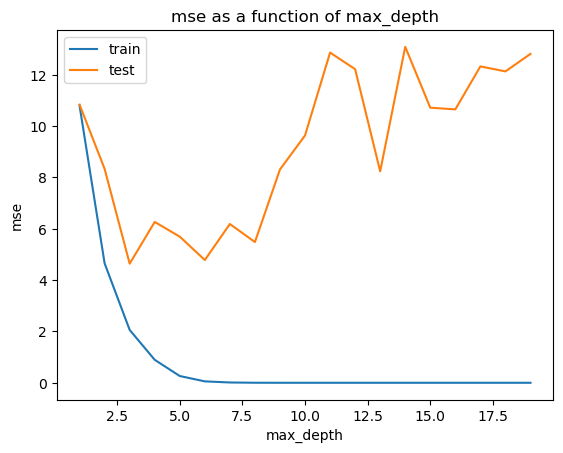

In [219]:
plt.plot(max_depth, mse_train, label="train")
plt.plot(max_depth, mse_test, label="test")
plt.xlabel("max_depth")
plt.ylabel("mse")
plt.title('mse as a function of max_depth')
plt.legend()
plt.show()

#### after depth>3 the model becomes over-fitted

#### 4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

 As the name suggests, early stopping stops the training process of the algorithm somewhere before the specified boosting rounds given by n_estimators. The stopping point can be monitored by plotting the learning curve.

In [220]:
# change "train" method to include train/val split, and make sure the val error doest go higher than the train error:
n_sweep = np.logspace(0,3, num=50).astype(int)
n_sweep =np.unique(n_sweep)
lr_sweep=[0.01,0.05,0.1,0.15]
mse_train = []
mse_test = []
for n in n_sweep:
    print(f"number of trees: {n}")
    GB = GradientBoosterD2(max_d=1,lr=0.1, n_iter=n)
    GB.train(X_train, y_train)
    y_pred = GB.predict(X_train)
    train_mse = np.square(np.subtract(y_train, y_pred)).mean() 
    mse_train.append(train_mse)
    print(f"train set mse:{train_mse:.2f} ")
    y_pred = GB.predict(X_test)
    test_mse = np.square(np.subtract(y_test, y_pred)).mean() 
    mse_test.append(test_mse)
    print(f"test set mse:{test_mse:.2f} ")
    # stop to avoid over-fitting:
    if test_mse>train_mse:
        print(f'the best number of itaration to avoid overfitting is {n}')
        break

number of trees: 1
train set mse:79.04 
test set mse:58.85 
number of trees: 2
train set mse:72.27 
test set mse:54.17 
number of trees: 3
train set mse:66.72 
test set mse:49.76 
number of trees: 4
train set mse:61.76 
test set mse:46.30 
number of trees: 5
train set mse:57.53 
test set mse:43.25 
number of trees: 6
train set mse:53.71 
test set mse:39.78 
number of trees: 7
train set mse:49.94 
test set mse:36.63 
number of trees: 8
train set mse:46.88 
test set mse:34.27 
number of trees: 9
train set mse:43.84 
test set mse:32.16 
number of trees: 10
train set mse:41.47 
test set mse:29.91 
number of trees: 12
train set mse:36.98 
test set mse:26.76 
number of trees: 14
train set mse:33.47 
test set mse:24.32 
number of trees: 16
train set mse:30.71 
test set mse:22.16 
number of trees: 19
train set mse:27.37 
test set mse:20.06 
number of trees: 22
train set mse:24.75 
test set mse:18.02 
number of trees: 25
train set mse:22.89 
test set mse:16.33 
number of trees: 29
train set mse